### **Importing libraries**


In [53]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

### **Integrating with google drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Data loading and Preprocessing**

In [2]:
header_list = ["ID", "label", "statement","subject","speaker","title of speaker","state","party","barely true","false","half true","mostly true","pants on fire","venue"]


In [5]:
train_dataset = pd.read_csv("/content/drive/MyDrive/MLProject/train.tsv",delimiter='\t',names=header_list)
test_dataset = pd.read_csv("/content/drive/MyDrive/MLProject/valid.tsv",delimiter='\t',names=header_list)
valid_dataset = pd.read_csv("/content/drive/MyDrive/MLProject/test.tsv",delimiter='\t',names=header_list)
dataset = train_dataset.merge(test_dataset,how='outer')
dataset = dataset.merge(valid_dataset,how='outer')
dataset.head()

,ID,label,statement,subject,speaker,title of speaker,state,party,barely true,false,half true,mostly true,pants on fire,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [6]:
dataset["label"].replace({"half-true": "true", "mostly-true": "true","barely-true":"false","pants-fire":"false"}, inplace=True)


In [7]:
dataset["label"].replace({"true": "0", "false":"1"}, inplace=True)

In [50]:
dataset['label'].value_counts()

0    7134
1    5657
Name: label, dtype: int64

In [78]:
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [79]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [80]:
wordnet_lemmatizer = WordNetLemmatizer()

In [83]:
for i in range(dataset.shape[0]):
    dataset['statement'][i] = re.sub('[^A-Za-z ]+', '',dataset['statement'][i])
    words = word_tokenize(dataset['statement'][i])
    words = [wordnet_lemmatizer.lemmatize(word.lower(), pos='v') for word in words if word not in set(stopwords.words('english'))]
    dataset['statement'][i] = ' '.join(words)

### **Visualization**

*Countplot*

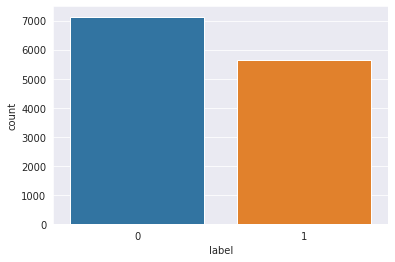

In [51]:
sns.set_style("darkgrid")
sns.countplot(dataset['label'])

*WordCloud for real news*

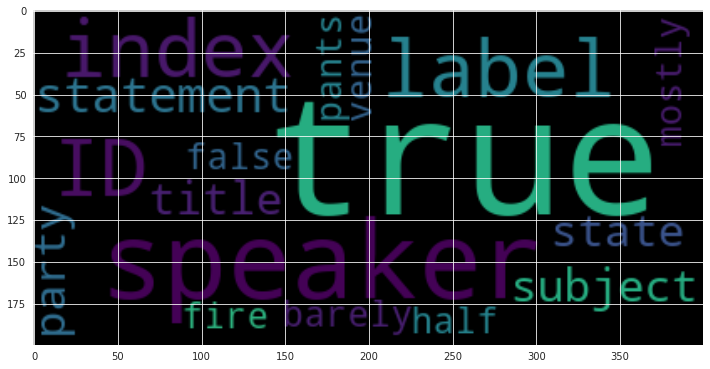

In [66]:
plt.figure(figsize = (12,12)) # Text that is not Fake
wc = WordCloud(width = 400, height = 200, max_font_size=100).generate(" ".join(dataset[dataset.label == 0]))
plt.imshow(wc , interpolation = 'bilinear');

*Wordcloud for fake news*

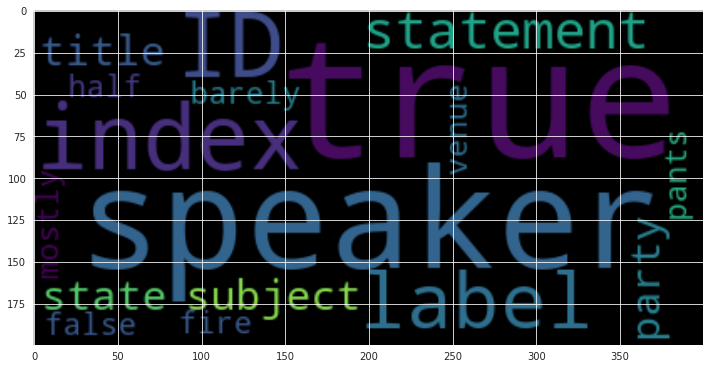

In [68]:
plt.figure(figsize = (12,12)) # Text that is Fake
wc = WordCloud(width = 400, height = 200, max_font_size=100).generate(" ".join(dataset[dataset.label == 1]))
plt.imshow(wc , interpolation = 'bilinear');

*Average word length in each text*

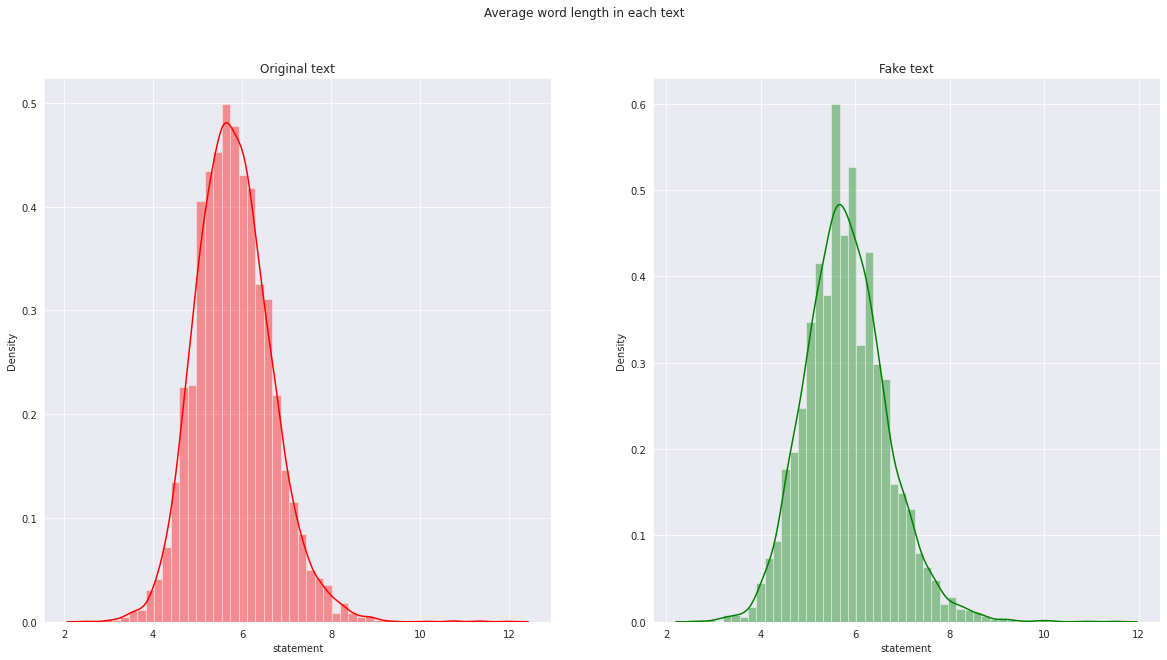

In [84]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=dataset[dataset['label']==0]['statement'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=dataset[dataset['label']==1]['statement'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text');

*Unigram analysis*

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

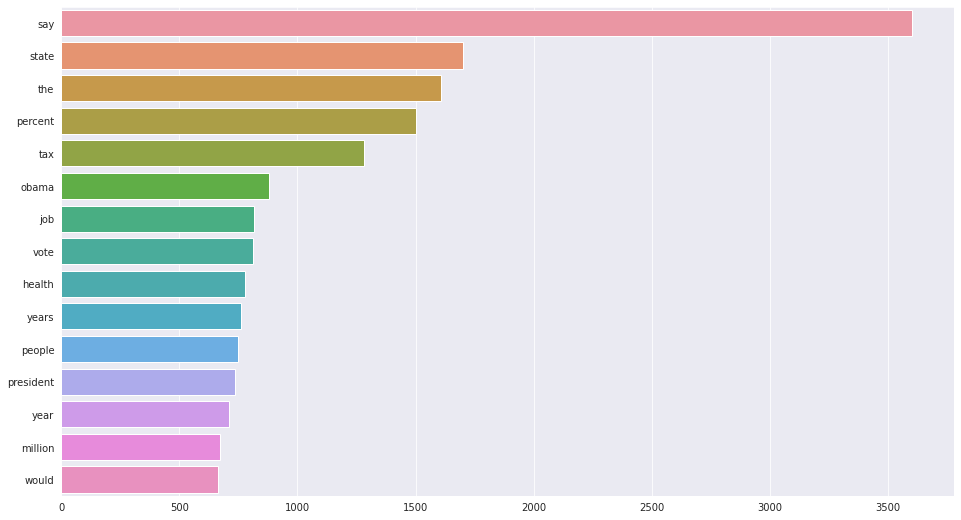

In [86]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(dataset['statement'],15,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

*Bigram analysis*

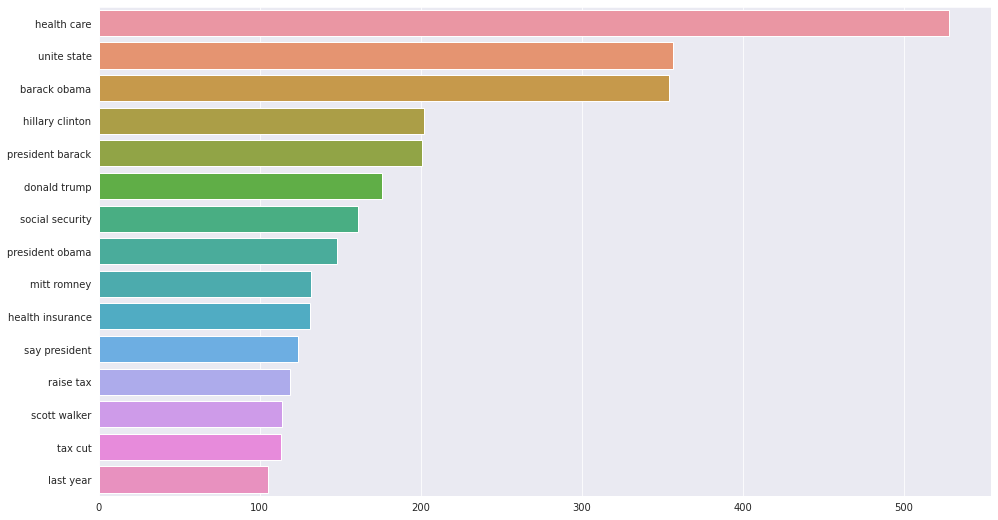

In [87]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(dataset['statement'],15,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

*Trigram analysis*

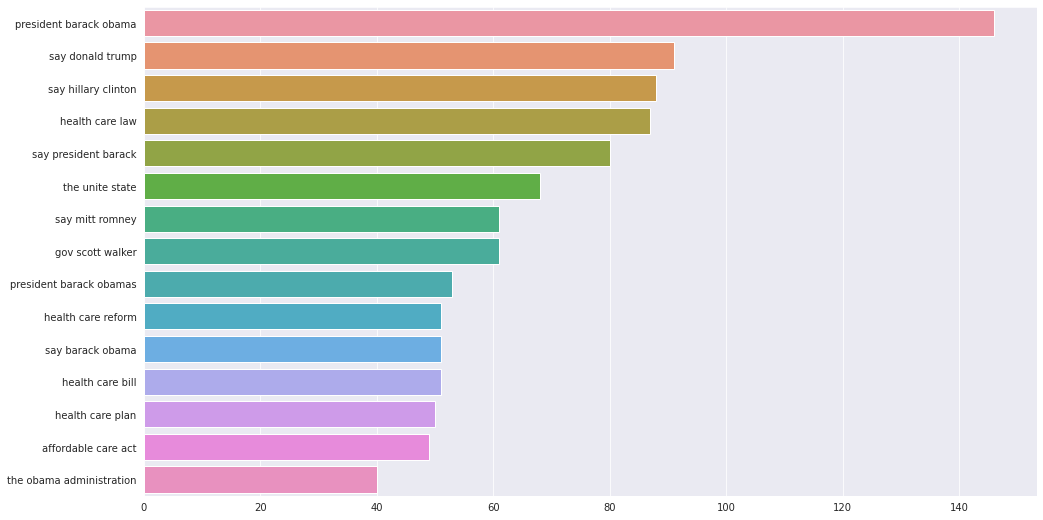

In [88]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(dataset['statement'],15,3)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

### **More data preprocessing**

In [8]:
dataset.dropna()
dataset.reset_index(inplace=True)

In [9]:
dataset["label"]= dataset["label"].astype(int)

In [11]:
dataset.head()

,index,ID,label,statement,subject,speaker,title of speaker,state,party,barely true,false,half true,mostly true,pants on fire,venue
0,0,2635.json,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,1,10540.json,0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,2,324.json,0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,3,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,4,9028.json,0,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


### **Splitting dataset**

In [12]:
from sklearn.model_selection import train_test_split

#.values returns a NumPy array instead of a Pandas Series object which is in this context easier to work with:
Xt = dataset['statement'].values
y = dataset['label'].values

Xt_train, Xt_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=100)

### **Vectorizing**

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Xt_train) #creating Vocabulory

X_train = tokenizer.texts_to_sequences(Xt_train)
X_test = tokenizer.texts_to_sequences(Xt_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(Xt_train[2])
print(X_train[2])

Says theres not much evidence to suggest that people have (contributed to global warming) or can do very much to change anything.
[7, 355, 28, 280, 1243, 4, 4893, 9, 34, 13, 2384, 4, 742, 1079, 59, 127, 144, 336, 280, 4, 372, 782]


In [14]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  31  380   24  395   10   37    5  188  266   31   70   57 3406 2383
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### **Building the Model**

In [16]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout,SimpleRNN

embedding_dim = 50
model=Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            605250    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               15100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 620,451
Trainable params: 620,451
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.save('/content/drive/MyDrive/MLProject/rnn_model.h5')    # Saveing the model

### **Generating the confusion matrix**

In [19]:
y_pred = model.predict_classes(X_test)
y_pred

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [45]:
print("Training Accuracy: %0.3f"%model.evaluate(X_train, y_train, verbose=False)[1])
 
print("Testing Accuracy: %0.3f"%model.evaluate(X_test, y_test, verbose=False)[1])

Training Accuracy: 0.992
Testing Accuracy: 0.556


In [98]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

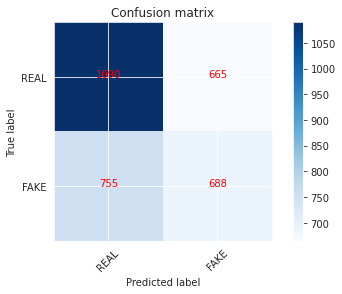

In [99]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['REAL', 'FAKE'])

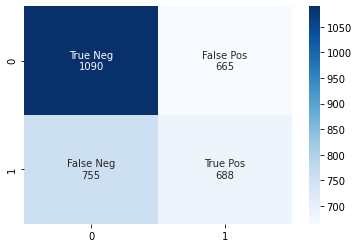

In [47]:
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in CM.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(labels,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(CM, annot=labels, fmt='', cmap='Blues')

In [48]:
CM_class_acc = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
CM_class_acc.diagonal()                # Classwise accuracy

array([0.62108262, 0.47678448])

### **Using pretrained glove for lstm**

In [24]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

with open('/content/drive/MyDrive/MLProject/glove.6B.200d.txt') as f:
  for line in f:
    word,*vector = line.split()
    if word in word_index:
      i = word_index[word] 
      embedding_matrix[i] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [25]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9359768690623709

### **LSTM**

In [36]:
from keras import layers

model_lstm = Sequential()
model_lstm.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen,
                           trainable = True))
model_lstm.add(LSTM(100))
model_lstm.add(layers.Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_lstm.summary()

history = model_lstm.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 200)           2421000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,541,501
Trainable params: 2,541,501
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_lstm.save('/content/drive/MyDrive/MLProject/lstm_model_binaryClassification.h5')   # Saving the model

### **Building Confusion matrix**

In [38]:
y_pred_lstm = model_lstm.predict_classes(X_test)
y_pred_lstm

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [39]:
from sklearn import metrics
CM_lstm = metrics.confusion_matrix(y_test, y_pred_lstm)
print(CM_lstm)

[[1053  702]
 [ 656  787]]


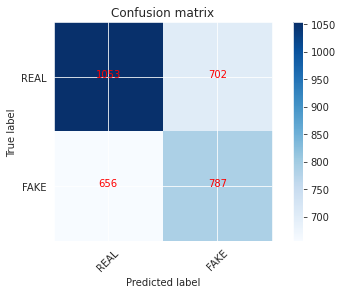

In [100]:
cm_lstm = metrics.confusion_matrix(y_test, y_pred_lstm)
plot_confusion_matrix(cm_lstm, classes=['REAL', 'FAKE'])

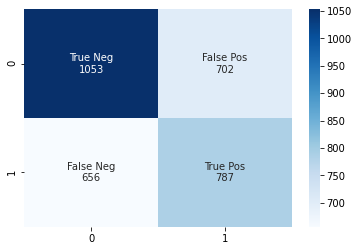

In [40]:
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in CM_lstm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(labels,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(CM_lstm, annot=labels, fmt='', cmap='Blues')

In [41]:
print("Training Accuracy: %0.3f"%model_lstm.evaluate(X_train, y_train, verbose=False)[1])
 
print("Testing Accuracy: %0.3f"%model_lstm.evaluate(X_test, y_test, verbose=False)[1])

Training Accuracy: 0.996
Testing Accuracy: 0.575


In [42]:
cm_lstm_class_acc = CM_lstm.astype('float') / CM_lstm.sum(axis=1)[:, np.newaxis]
cm_lstm_class_acc.diagonal()   # Classwise accuracies

array([0.6       , 0.54539155])

### **LSTM 54% accuracy for fake news**